In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
from tqdm import notebook
import sys

from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import *
from keras.callbacks import ModelCheckpoint
import keras.backend as K
import tensorflow as tf
from keras.utils.vis_utils import plot_model

In [ ]:
def rect_coords(X1, Y1, width, height, angle):
        if width >0 and height >0:
            
            theta = angle*(np.pi/180.)
            alpha = np.arctan(height/width)
            hypot = np.sqrt(width**2 + height**2)

            x1, y1 = X1, Y1
            x2, y2 = x1+width*np.cos(theta), y1+width*np.sin(theta)
            x3, y3 = x1+hypot*np.cos(theta+alpha), y1+hypot*np.sin(theta+alpha)
            x4, y4 = x1-height*np.sin(theta), y1+height*np.cos(theta)
            rect_coords = [[x1, y1], [x2, y2], [x3, y3], [x4, y4], [x1, y1]]

        else:
            rect_coords = np.zeros((5,2))
            
        rect_coords = np.array(rect_coords)

        return rect_coords

In [3]:
def iou_calc(bbox1, bbox2):
    Ax1, Ay1, Ax2, Ay2 = max(0, bbox1[0][0]), max(0, bbox1[0][1]), max(0, bbox1[1][0]), max(0, bbox1[1][1])
    Bx1, By1, Bx2, By2 = max(0, bbox2[0][0]), max(0, bbox2[0][1]), max(0, bbox2[1][0]), max(0, bbox2[1][1])

    #inter rect
    Ix1 = max(Ax1, Bx1)
    Iy1 = max(Ay1, By1)
    Ix2 = min(Ax2, Bx2)
    Iy2 = min(Ay2, By2)

    inter_area = max(0, (Ix2-Ix1)*(Iy2-Iy1))

    area_rect1 = max(0, (Ax2-Ax1)*(Ay2-Ay1))
    area_rect2 = max(0, (Bx2-Bx1)*(By2-By1))

    union_area = max(0, area_rect1 + area_rect2 - inter_area)
    
    if union_area == 0:
        IOU = 0
    else:
        IOU = inter_area/union_area

    return IOU

In [4]:
img_ht, img_wd = 76,76

shapes = ['Rectangle', 'Circle', 'Triangle', 'Pentagon', 'Hexagon']

max_shapes = 3

num_classes = len(shapes) + 1

GRID = 5

BATCH_SIZE = 32

In [5]:
src_dir = '../input/your/source/directory'

In [6]:
img_files = os.listdir(os.path.join(src_dir, 'Images'))
mask_files = os.listdir(os.path.join(src_dir, 'Masks'))

In [7]:
Images = []
Labels = []
Masks = []


for img_file in notebook.tqdm(img_files):
    # Writing image to array
    img = cv2.imread(os.path.join(src_dir, 'Images', img_file), 0)
    img = cv2.resize(img, (img_ht,img_wd))
    
    Images.append(img.reshape(img_ht, img_wd, 1)/255.)
    
    #Writing label to array
    lab_file = 'Lab_' + img_file.split('_')[-1].split('.')[0] + '.txt'
    label = np.genfromtxt(os.path.join(src_dir, 'Labels_yolo', lab_file), delimiter = ',')
    
    Labels.append(label.reshape(GRID,GRID,5+len(shapes)+1))
    
    mask_arr = []
    mask_str = 'Mask_' + img_file.split('_')[-1].split('.')[0] + '_'
    mask_ind = [ind for ind, name in enumerate(os.listdir(os.path.join(src_dir, 'Masks'))) if mask_str in name]
    #Writing masks to array
    newimg = np.zeros((img.shape[0], img.shape[1]))
    for ind in mask_ind:
        if mask_files[ind].split('_')[-1].split('.')[0] != 'Empty':
            shape = mask_files[ind].split('_')[-1].split('.')[0]
            maskimg = cv2.imread(os.path.join(src_dir, 'Masks', mask_files[ind]), 0)
            maskimg = cv2.resize(maskimg, (img.shape[0], img.shape[1]))
            
            i = shapes.index(shape)
            for j in range(img.shape[0]):
                for k in range(img.shape[1]):
                    if maskimg[j,k] == 0:
                        newimg[j,k] = i+1
           
    Masks.append(newimg.reshape(img_ht, img_wd, 1))
                            
Images = np.array(Images)
Labels = np.array(Labels)
Masks = keras.utils.to_categorical(np.array(Masks), (len(shapes)+1))
# Masks = np.array(Masks)

print(Images.shape, Labels.shape, Masks.shape)


(5000, 76, 76, 1) (5000, 5, 5, 11) (5000, 76, 76, 6)


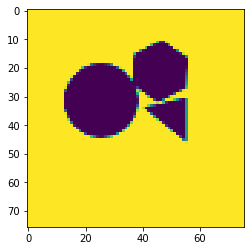

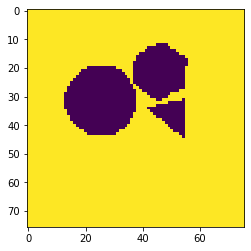

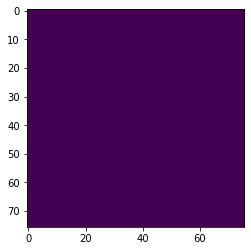

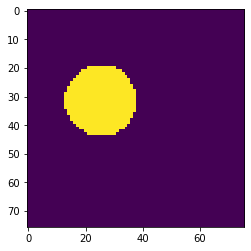

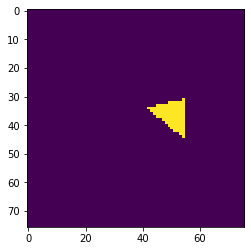

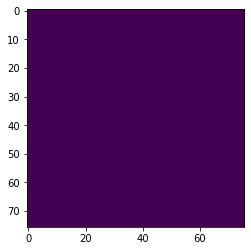

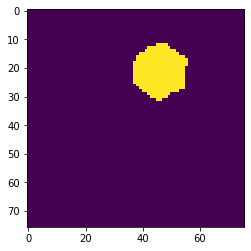

In [8]:
ind = random.randint(0,99)
plt.figure()
plt.imshow(Images[ind].reshape(76,76))
for i in range(len(shapes)+1):
    plt.figure()
    plt.imshow(Masks[ind,:,:,i].reshape(76,76))


In [9]:
main_input = Input(shape=(img_ht,img_wd,1), name = 'img_input')

''' ~~~~~~~~~~~~~~~~~~~ ENCODING LAYERS ~~~~~~~~~~~~~~~~~~~ '''

c1 = Conv2D(32, kernel_size=(3,3), padding = 'same')(main_input)
c1 = LeakyReLU(0.2)(c1)
c1 = BatchNormalization()(c1)
c1 = Conv2D(32, kernel_size=(3,3), padding = 'same')(c1)
c1 = LeakyReLU(0.2)(c1)
c1 = BatchNormalization()(c1)

p1 = MaxPooling2D((2,2))(c1)

c2 = Conv2D(32*2, kernel_size=(3,3), padding = 'same')(p1)
c2 = LeakyReLU(0.2)(c2)
c2 = BatchNormalization()(c2)
c2 = Conv2D(32*2, kernel_size=(3,3), padding = 'same')(c2)
c2 = LeakyReLU(0.2)(c2)
c2 = BatchNormalization()(c2)

p2 = MaxPooling2D((2,2))(c2)

c3 = Conv2D(32*4, kernel_size=(3,3), padding = 'same')(p2)
c3 = LeakyReLU(0.2)(c3)
c3 = BatchNormalization()(c3)
c3 = Conv2D(32*2, kernel_size=(1,1), padding = 'same')(c3)
c3 = LeakyReLU(0.2)(c3)
c3 = BatchNormalization()(c3)
c3 = Conv2D(32*4, kernel_size=(3,3), padding = 'same')(c3)
c3 = LeakyReLU(0.2)(c3)
c3 = BatchNormalization()(c3)

p3 = MaxPooling2D((2,2))(c3)

c4 = Conv2D(32*6, kernel_size=(3,3), padding = 'same')(p3)
c4 = LeakyReLU(0.2)(c4)
c4 = BatchNormalization()(c4)
c4 = Conv2D(32*4, kernel_size=(1,1), padding = 'same')(c4)
c4 = LeakyReLU(0.2)(c4)
c4 = BatchNormalization()(c4)
c4 = Conv2D(32*6, kernel_size=(3,3), padding = 'same')(c4)
c4 = LeakyReLU(0.2)(c4)
c4 = BatchNormalization()(c4)

p4 = MaxPooling2D((2,2))(c4)

c5 = Conv2D(32*6, kernel_size=(3,3), padding = 'same')(p4)
c5 = LeakyReLU(0.2)(c5)
c5 = BatchNormalization()(c5)

''' ~~~~~~~~~~~~~~~~~~~ YOLO OUTPUT ~~~~~~~~~~~~~~~~~~~ '''

x = GlobalMaxPooling2D()(c5)

x1 = Dense(1024, activation = 'relu')(x)

x1 = Dropout(0.3)(x1)

x1 = Dense(GRID*GRID*(5+len(shapes)+1), activation = 'sigmoid')(x1)

yolo_out = Reshape((GRID, GRID, (5+len(shapes)+1)), name = 'yolo_out')(x1)

''' ~~~~~~~~~~~~~~~~~~~ DECODING LAYERS ~~~~~~~~~~~~~~~~~~~ '''

u1 = UpSampling2D((2,2))(c5)
concat1 = concatenate([u1, Cropping2D(((1,0), (1,0)))(c4)])

c6 = Conv2D(32*4, kernel_size=(3,3), padding = 'same')(concat1)
c6 = LeakyReLU(0.2)(c6)
c6 = BatchNormalization()(c6)
c6 = Conv2D(32*4, kernel_size=(3,3), padding = 'same')(c6)
c6 = LeakyReLU(0.2)(c6)
c6 = BatchNormalization()(c6)


u2 = UpSampling2D((2,2))(c6)
concat2 = concatenate([Cropping2D(((2,1), (2,1)))(c3), u2])

c7 = Conv2D(32*2, kernel_size=(3,3), padding = 'same')(concat2)
c7 = LeakyReLU(0.2)(c7)
c7 = BatchNormalization()(c7)
c7 = Conv2D(32*2, kernel_size=(3,3), padding = 'same')(c7)
c7 = LeakyReLU(0.2)(c7)
c7 = BatchNormalization()(c7)

u3 = UpSampling2D((2,2))(c7)
concat3 = concatenate([Cropping2D(((3,3), (3,3)))(c2), u3])

c8 = Conv2D(32, kernel_size=(3,3), padding = 'same')(concat3)
c8 = LeakyReLU(0.2)(c8)
c8 = BatchNormalization()(c8)
c8 = Conv2D(32, kernel_size=(3,3), padding = 'same')(c8)
c8 = LeakyReLU(0.2)(c8)
c8 = BatchNormalization()(c8)

u4 = UpSampling2D((3,3))(c8)
concat4 = concatenate([c1, Cropping2D((10,10))(u4)])

c9 = Conv2D(16, kernel_size = (1,1), padding = 'same')(concat4)
c9 = LeakyReLU(0.2)(c9)
c9 = BatchNormalization()(c9)

mask_out = Conv2D(len(shapes)+1, (1,1), padding = 'same', activation = 'sigmoid', name = 'mask_out')(c9)

model = Model(inputs = [main_input], outputs = [yolo_out, mask_out])

# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          (None, 76, 76, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 76, 76, 32)   320         img_input[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 76, 76, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 76, 76, 32)   128         leaky_re_lu_1[0][0]              
____________________________________________________________________________________________

In [10]:
def yolo_loss (y_true, y_pred):

    x_loss = K.sum((K.square(y_pred[...,1] - y_true[...,1]))*y_true[...,0])
    y_loss = K.sum((K.square(y_pred[...,2] - y_true[...,2]))*y_true[...,0])
    w_loss = K.sum((K.square(y_pred[...,3] - y_true[...,3]))*y_true[...,0])
    h_loss = K.sum((K.square(y_pred[...,4] - y_true[...,4]))*y_true[...,0])
    
    #category loss
    pc_loss = K.categorical_crossentropy(y_true[...,5:], y_pred[...,5:])*y_true[...,0]
    
    #confidence loss
    c_loss = K.binary_crossentropy(y_true[...,0], y_pred[...,0])
    
    total_loss = x_loss + y_loss + w_loss + h_loss + pc_loss + c_loss 
    
    return total_loss

In [11]:
loss_funcs = {
    "yolo_out": yolo_loss,
    "mask_out": 'categorical_crossentropy'
}

model.compile(optimizer = 'adam', loss = loss_funcs, metrics = ['accuracy'])

In [12]:
# filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [checkpoint]

In [13]:
history = model.fit(Images, {"yolo_out": Labels, "mask_out": Masks}, batch_size = 32, 
          epochs = 75, validation_split = 0.1)

Train on 4500 samples, validate on 500 samples
Epoch 1/75
4500/4500 [==============================] - 17s 4ms/step - loss: 3.7632 - yolo_out_loss: 2.6381 - mask_out_loss: 1.1196 - yolo_out_accuracy: 0.0020 - mask_out_accuracy: 0.6627 - val_loss: 2.9249 - val_yolo_out_loss: 2.3002 - val_mask_out_loss: 0.6129 - val_yolo_out_accuracy: 0.0000e+00 - val_mask_out_accuracy: 0.9245
Epoch 2/75
4500/4500 [==============================] - 8s 2ms/step - loss: 1.5522 - yolo_out_loss: 1.0514 - mask_out_loss: 0.4996 - yolo_out_accuracy: 0.0000e+00 - mask_out_accuracy: 0.8562 - val_loss: 2.4532 - val_yolo_out_loss: 2.1776 - val_mask_out_loss: 0.2638 - val_yolo_out_accuracy: 0.0000e+00 - val_mask_out_accuracy: 0.9225
Epoch 3/75
4500/4500 [==============================] - 8s 2ms/step - loss: 1.1101 - yolo_out_loss: 0.8524 - mask_out_loss: 0.2566 - yolo_out_accuracy: 6.2222e-05 - mask_out_accuracy: 0.9062 - val_loss: 2.3959 - val_yolo_out_loss: 2.1839 - val_mask_out_loss: 0.1978 - val_yolo_out_accurac

Epoch 26/75
4500/4500 [==============================] - 8s 2ms/step - loss: 0.3140 - yolo_out_loss: 0.3070 - mask_out_loss: 0.0067 - yolo_out_accuracy: 0.0642 - mask_out_accuracy: 0.9976 - val_loss: 0.2967 - val_yolo_out_loss: 0.2771 - val_mask_out_loss: 0.0188 - val_yolo_out_accuracy: 0.0678 - val_mask_out_accuracy: 0.9926
Epoch 27/75
4500/4500 [==============================] - 7s 2ms/step - loss: 0.3053 - yolo_out_loss: 0.2970 - mask_out_loss: 0.0083 - yolo_out_accuracy: 0.0640 - mask_out_accuracy: 0.9969 - val_loss: 0.2742 - val_yolo_out_loss: 0.2444 - val_mask_out_loss: 0.0287 - val_yolo_out_accuracy: 0.0637 - val_mask_out_accuracy: 0.9896
Epoch 28/75
4500/4500 [==============================] - 7s 2ms/step - loss: 0.3015 - yolo_out_loss: 0.2939 - mask_out_loss: 0.0074 - yolo_out_accuracy: 0.0650 - mask_out_accuracy: 0.9973 - val_loss: 0.2904 - val_yolo_out_loss: 0.2332 - val_mask_out_loss: 0.0567 - val_yolo_out_accuracy: 0.0656 - val_mask_out_accuracy: 0.9828
Epoch 29/75
4500/45

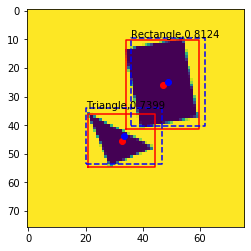

In [31]:
index = random.randint(0, len(Images))

img = Images[index]
true_yolo_lab = Labels[index].reshape(GRID*GRID, 11)
mask = Masks[index]

centers = []
bboxs = []
cats = []
for lab_arr in (true_yolo_lab):
    if lab_arr[0] == 1:
        centers.append([lab_arr[1], lab_arr[2]])
        bboxs.append([lab_arr[1]-lab_arr[3]*0.5, lab_arr[2]-lab_arr[4]*0.5, lab_arr[3], lab_arr[4]])
        cats.append(np.argmax(lab_arr[5:]))
        
plt.imshow(img.reshape(76,76))

true_center_dists = [] 
for i in range(len(centers)):
    true_center_dists.append((centers[i][0]**2 + centers[i][1]**2)*100)
    plt.scatter(centers[i][0]*76,76-76*centers[i][1], c='r')
    bbox = rect_coords(bboxs[i][0], bboxs[i][1], bboxs[i][2], bboxs[i][3], 0)
    plt.plot(bbox[:,0]*76, 76-76*bbox[:,1], 'r')
    
sorted_indices_t = np.argsort(true_center_dists)
# print(sorted_indices_t)
    
preds = model.predict(img.reshape(1,76,76,1))

yolo_preds = preds[0].reshape(GRID*GRID,11)

centers_p = []
bbox_p = []
cats_p = []
centers_p_dists = []
for lab_arr in (yolo_preds):
    if lab_arr[0] > 0.25:
        centers_p.append([lab_arr[1], lab_arr[2]])
        centers_p_dists.append((centers_p[-1][0]**2 + centers_p[-1][1]**2)*100)
        bbox_p.append([lab_arr[1]-lab_arr[3]*0.5, lab_arr[2]-lab_arr[4]*0.5, lab_arr[3], lab_arr[4]])
        cats_p.append(np.argmax(lab_arr[5:]))

sorted_indices_p = np.argsort(centers_p_dists)
# print(sorted_indices_p) 
    
for i in range(len(centers_p)):
    plt.scatter(centers_p[sorted_indices_p[i]][0]*76,76-76*centers_p[sorted_indices_p[i]][1], c='b')
    bbox = rect_coords(bbox_p[sorted_indices_p[i]][0], bbox_p[sorted_indices_p[i]][1], bbox_p[sorted_indices_p[i]][2], bbox_p[sorted_indices_p[i]][3], 0)
    plt.plot(bbox[:,0]*76, 76-76*bbox[:,1], '--b')
    
    bbox1 = np.array([bbox_p[sorted_indices_p[i]][0], bbox_p[sorted_indices_p[i]][1], bbox_p[sorted_indices_p[i]][2]+bbox_p[sorted_indices_p[i]][0], bbox_p[sorted_indices_p[i]][3]+bbox_p[sorted_indices_p[i]][1]])
    bbox2 = np.array([bboxs[sorted_indices_t[i]][0], bboxs[sorted_indices_t[i]][1], bboxs[sorted_indices_t[i]][2]+bboxs[sorted_indices_t[i]][0], bboxs[sorted_indices_t[i]][3]+bboxs[sorted_indices_t[i]][1]])
    iou_score = iou_calc(bbox1.reshape(2,2), bbox2.reshape(2,2))
    
    category = cats_p[sorted_indices_p[i]]
    
    text = str(shapes[category-1]) + ',' + str(round(iou_score,4)) 
    plt.text((bbox_p[sorted_indices_p[i]][0])*76,76-76*(bbox_p[sorted_indices_p[i]][3]+bbox_p[sorted_indices_p[i]][1]), text)
    
    

In [32]:
def mask_iou(truemask, maskimg):
       
    intersection = np.count_nonzero(truemask*maskimg)
#     print(intersection)

    union = np.count_nonzero(truemask) + np.count_nonzero(maskimg) - intersection
#     print(union)
    
    if union > 0:
        iou_mask = intersection/union
    else:
        return 1
    
    return iou_mask


Mean mask IOU = 0.9901425881086897


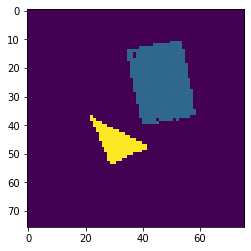

In [33]:
mask_pred = preds[1].reshape(76,76,len(shapes)+1)
mask_pred_1 = np.zeros((76,76,len(shapes)+1))
mask_pred_img = np.zeros((mask_pred.shape[0], mask_pred.shape[1]))

maskiou = []
for i in range(mask_pred.shape[2]):
    for j in range(mask_pred.shape[0]):
        for k in range(mask_pred.shape[1]):
            if mask_pred[j,k,i] > 0.02:
                mask_pred_img[j,k] = i
                mask_pred_1[j,k,i] = i
    
    if i > 0:
        maskiou.append(mask_iou(mask_pred_1[:,:,i], mask[:,:,i]))

print("Mean mask IOU = {}".format(np.mean(maskiou)))
plt.figure()
# plt.imshow(img.reshape(76,76))
plt.imshow(mask_pred_img)